In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit

In [33]:
def extraccion(datos):
    t = datos[2:].T[0] # segundos
    lista_pos=[]
    lista_bien  = []
    for i in range(1, len(datos[0]), 2):
        xy = []
        for j in datos:
            if np.isnan(j[i]) == False: 
                xy.append([j[i], j[i+1]])
        xy = np.array(xy)
        lista_pos.append(xy)
    for part in lista_pos:
        np.stack(part)
        lista_bien.append(pixel_a_micron(part.T)*1e-6)
    return t, lista_bien

def MSD(x,y):
    suma=0
    for n in range(len(x)):
        suma+=(x[n]-x[0])**2+(y[n]-y[0])**2

    return suma/len(x)

def MSD_data(lista_bien):
    lista_MSD = []
    for n, part in enumerate(lista_bien):
        x = part[0]
        y = part[1]
        part_MSD = []
        for i in range(len(x)):    
            msd = MSD(x[:i+1], y[:i+1])
            part_MSD.append(msd)
        lista_MSD.append(part_MSD)
    return lista_MSD

def promedio(lista_MSD):
    MSD_promedio = []
    for n in range(len(lista_MSD[0])-1): # como hay un frame menos en la partícula 8 promedio hasta ese 
        val = 0
        for disp in lista_MSD:
            val += disp[n]
        MSD_promedio.append(val/len(lista_MSD))
    return MSD_promedio

def lineal(x, a, b):
    return a*x + b

def viscosidad(m, R, T, err_m, err_R, err_T):
    neff = 2*1.38*1e-23*T/(3*np.pi*R*m)
    err_neff = 0 # propagación de errores
    return neff, err_neff

def pixel_a_micron(pix): # toma píxeles devuelve micrones
    escala = 10/106.04
    micro = pix*escala
    return micro

def celsius_a_k(g):
    return g+273.15

In [34]:
datos_aguaMQ = np.genfromtxt('Mediciones/browniano solo agua pixel.txt', delimiter=',')
datos_1_en_2 = np.genfromtxt('Mediciones/browniano 1 en 2 pixel.txt', delimiter=',')

t_aguaMQ, lista_aguaMQ = extraccion(datos_aguaMQ)
t_1_en_2, lista_1_en_2 = extraccion(datos_1_en_2)

lista_tiempos = [t_aguaMQ, t_1_en_2]

In [35]:
lista_MSD_aguaMQ = MSD_data(lista_aguaMQ)
lista_MSD_1_en_2 = MSD_data(lista_1_en_2)

MSD_prom_aguaMQ = promedio(lista_MSD_aguaMQ)
MSD_prom_1_en_2 = promedio(lista_MSD_1_en_2)

In [44]:
popt_lin, pcov_lin = curve_fit(lineal, t_aguaMQ[:len(MSD_prom_aguaMQ)], MSD_prom_aguaMQ, p0=[50, 0])
m_amq, b_amq = popt_lin
perr_lin = np.sqrt(np.diag(pcov_lin))
err_m_amq, err_b_amq = perr_lin

# R^2 lineal:
res_lin = MSD_prom_aguaMQ - lineal(t_aguaMQ[:len(MSD_prom_aguaMQ)], *popt_lin)
ss_res_lin = np.sum(res_lin**2)
ss_tot_lin = np.sum((MSD_prom_aguaMQ - np.mean(MSD_prom_aguaMQ))**2)
r_cuadrado_lin_amq = 1 - (ss_res_lin / ss_tot_lin)

print(f'Ajuste lineal agua MQ m*x + b\nm = {m_amq} +- {err_m_amq}\nb1 = {b_amq} +- {err_b_amq}\nR^2 = {r_cuadrado_lin_amq}\n')

popt_lin, pcov_lin = curve_fit(lineal, t_1_en_2[:len(MSD_prom_1_en_2)], MSD_prom_1_en_2, p0=[50, 0])
m_12, b_12 = popt_lin
perr_lin = np.sqrt(np.diag(pcov_lin))
err_m_12, err_b_12 = perr_lin

# R^2 lineal:
res_lin = MSD_prom_1_en_2 - lineal(t_1_en_2[:len(MSD_prom_1_en_2)], *popt_lin)
ss_res_lin = np.sum(res_lin**2)
ss_tot_lin = np.sum((MSD_prom_1_en_2 - np.mean(MSD_prom_1_en_2))**2)
r_cuadrado_lin_12 = 1 - (ss_res_lin / ss_tot_lin)

print(f'Ajuste lineal 1 en 2 m*x + b\nm = {m_12} +- {err_m_12}\nb1 = {b_12} +- {err_b_12}\nR^2 = {r_cuadrado_lin_12}\n')

Ajuste lineal agua MQ m*x + b
m = 1.2190522311182813e-13 +- 1.2799146154808475e-15
b1 = 6.534286811601473e-13 +- 3.321398748117176e-14
R^2 = 0.9309359241738018

Ajuste lineal 1 en 2 m*x + b
m = 3.399566585816262e-13 +- 1.4474606501347135e-15
b1 = -2.696577374048685e-13 +- 3.472067531160612e-14
R^2 = 0.9888496883722956



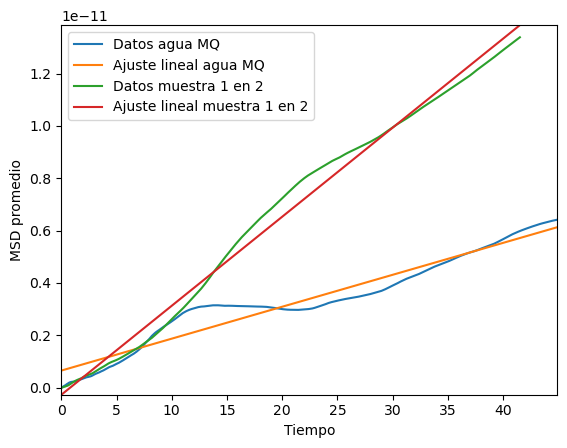

In [46]:
fig, ax = plt.subplots()

# agua MQ:
x = np.linspace(t_aguaMQ[0], t_aguaMQ[:len(MSD_prom_aguaMQ)][-1], 1000)
y_fit_lin = lineal(x, m_amq, b_amq)

ax.plot(t_aguaMQ[:len(MSD_prom_aguaMQ)], MSD_prom_aguaMQ, label='Datos agua MQ')
ax.plot(x, y_fit_lin, label='Ajuste lineal agua MQ')

# 1 en 2:
x = np.linspace(t_1_en_2[0], t_1_en_2[:len(MSD_prom_1_en_2)][-1], 1000)
y_fit_lin = lineal(x, m_12, b_12)

ax.plot(t_1_en_2[:len(MSD_prom_1_en_2)], MSD_prom_1_en_2, label='Datos muestra 1 en 2')
ax.plot(x, y_fit_lin, label='Ajuste lineal muestra 1 en 2')

ax.set_xlabel('Tiempo')
ax.set_ylabel('MSD promedio')
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.legend()

In [51]:
radio_px = 50
radio = pixel_a_micron(50)*1e-6 # el 1e-6 lo pasa a metros para tener el neff en unidades razonables

T_celsius = 25.5
T = celsius_a_k(T_celsius)

neff_amq, nerr_amq = viscosidad(m_amq, radio, T, 0, 0, 0)
Fuerza_v_amq = 6*np.pi*neff_amq*radio*8*1e-6

neff_12, nerr_12 = viscosidad(m_12, radio, T, 0, 0, 0)
Fuerza_v_12 = 6*np.pi*neff_12*radio*5*1e-6

print(neff_amq, neff_12)
print(Fuerza_v_amq, Fuerza_v_12)

0.0015215207335387087 0.0005456028579207051
1.0818555319735403e-12 2.424644375077258e-13
